In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [5]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

#Fake dataset
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/return_feature/return_feature_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

In [6]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv']

data_classification = data.copy()
test_classification = test_data.copy()
fake_Classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_Classification = fake_Classification.drop(columns = keep_features)

In [7]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc

from sklearn.utils import shuffle

results_summary = []

def method_evaluation(model, data_x, data_y, X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2,
                                                           random_state=42, stratify=data_y)
        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )

        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'Undersampling':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)
        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
        X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
        y_train = data_under[['loan_status']]  # Target (타겟 변수)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'SMOTE':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

        smote = SMOTE(random_state=42)

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
        X_train = augmentation_data.drop(columns='loan_status')
        y_train = augmentation_data[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'table-gan':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    

    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)

    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    au_prc = auc(recall, precision)

    results_summary.append({
        'Method': method,
        'Recall_0': recall_0,
        'Precision_0': precision_0,
        'F1_0': f1_0,
        'Recall_1': recall_1,
        'Precision_1': precision_1,
        'F1_1': f1_1,
        'AU_PRC': au_prc
    })

In [9]:
Methods = ['Base', 'Undersampling', 'SMOTE', 'table-gan']

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification['loan_status']

returns_df = pd.DataFrame()

for method in Methods:
    data_x = data_classification.drop(columns='loan_status')
    data_y = data_classification['loan_status']

    model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    )

    method_evaluation(model, data_x, data_y, X_test, y_test, method)

results_df = pd.DataFrame(results_summary)

Preprocessing method : Base
[0]	validation_0-logloss:0.49195	validation_1-logloss:0.49198
[1]	validation_0-logloss:0.48735	validation_1-logloss:0.48740
[2]	validation_0-logloss:0.48287	validation_1-logloss:0.48294
[3]	validation_0-logloss:0.47852	validation_1-logloss:0.47860
[4]	validation_0-logloss:0.47427	validation_1-logloss:0.47438
[5]	validation_0-logloss:0.47013	validation_1-logloss:0.47026
[6]	validation_0-logloss:0.46610	validation_1-logloss:0.46624
[7]	validation_0-logloss:0.46217	validation_1-logloss:0.46233
[8]	validation_0-logloss:0.45833	validation_1-logloss:0.45851
[9]	validation_0-logloss:0.45459	validation_1-logloss:0.45478
[10]	validation_0-logloss:0.45093	validation_1-logloss:0.45114
[11]	validation_0-logloss:0.44735	validation_1-logloss:0.44758
[12]	validation_0-logloss:0.44386	validation_1-logloss:0.44411
[13]	validation_0-logloss:0.44044	validation_1-logloss:0.44071
[14]	validation_0-logloss:0.43710	validation_1-logloss:0.43738
[15]	validation_0-logloss:0.43384	val

In [10]:
results_df

,Method,Recall_0,Precision_0,F1_0,Recall_1,Precision_1,F1_1,AU_PRC
0,Base,0.937007,0.938911,0.937958,0.748437,0.742225,0.745318,0.802434
1,Undersampling,0.862876,0.974317,0.915217,0.906145,0.615601,0.733136,0.798541
2,SMOTE,0.908986,0.955268,0.931552,0.824364,0.687015,0.749448,0.777795
3,table-gan,0.898043,0.952572,0.924504,0.815499,0.659676,0.729358,0.729869


## SMOTified - GAN 적용

In [11]:
data['loan_status'].value_counts()

loan_status
0    898669
1    217789
Name: count, dtype: int64

In [12]:
data_x = data.drop(columns='loan_status')
data_y = data['loan_status']  # Series로 사용해야 fit_resample 가능

# 2. class 분포 확인
class_0_count = data_y.value_counts()[0]
target_class_1 = class_0_count // 2  # class 1을 class 0의 절반으로 맞추기

# 3. sampling_strategy 설정
# 'minority': 전체 맞춤, float: 전체에 대한 비율, dict: 직접 수 지정
sampling_strategy = {0: class_0_count, 1: target_class_1}

# 4. SMOTE 적용
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(data_x, data_y)

# 5. 결과 결합
augmentation_data = pd.concat([X_train_smote, y_train_smote], axis=1)

In [13]:
augmentation_data['loan_status'].value_counts()

loan_status
0    898669
1    449334
Name: count, dtype: int64

In [ ]:
"""class_1_oversampled = augmentation_data[augmentation_data['loan_status'] == 1]

oversample_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
class_1_oversampled.to_csv(path_or_buf=oversample_path+"oversampled.csv", index=False)"""

## Stratified - Tablegan modeling

In [42]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

#Fake dataset
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/oversampled/oversampled_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

In [16]:
for col in fake.columns:
    print(f"{col} feature values :\n{fake[col].unique()}\n")

last_fico_range_high feature values :
[574.54519027 498.00158551 610.12965455 ... 539.8418661  605.12932433
 644.72682631]

mo_sin_old_rev_tl_op feature values :
[143.55146027 211.36269615 192.95228883 ... 227.36089006 261.2383739
 288.49187218]

int_rate feature values :
[0.17110761 0.1378229  0.10362656 ... 0.12154876 0.21197161 0.11588333]

annual_inc feature values :
[ 79855.23898303 201533.40454836  71535.35478687 ...   9802.51782929
   9110.3477389   10411.96114127]

dti feature values :
[21.95217471 14.39981046 22.71966499 ... 13.63367747 33.5472031
  8.61338846]

installment feature values :
[ 195.45        699.37509321  176.96791959 ... 1114.09        525.45186977
  696.11325994]

zip_code feature values :
[643.23581965  30.69295277 225.76370922 ...  65.45372754 103.16732882
 757.23513254]

revol_util feature values :
[0.29733875 0.61572948 0.22841934 ... 0.46249364 0.35576178 0.82064746]

fico_range_low feature values :
[678.82394534 712.45470555 695.33483069 ... 701.28334012

In [43]:
## Term months preprocessing
def term_months(x):
    return 36 if abs(x-36)<abs(x-60) else 60

fake['term_months'] = fake['term_months'].apply(term_months)

In [5]:
fake['term_months'].value_counts()

term_months
36    277091
60    182909
Name: count, dtype: int64

In [44]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv']

data_classification = data.copy()
test_classification = test_data.copy()
fake_Classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_Classification = fake_Classification.drop(columns = keep_features)

In [45]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [46]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 893166 samples (80.0%)
Validation size: 223292 samples (20.0%)
Test size: 744306 samples (66.7%)


In [47]:
from sklearn.utils import shuffle

train_dataset = pd.concat([X_train, y_train], axis=1)
train_total = pd.concat([train_dataset,fake_Classification])
train_total = shuffle(train_total, random_state=42)

In [48]:
X_train = train_total.drop(columns='loan_status')
y_train = train_total[['loan_status']]

In [49]:
train_total['loan_status'].value_counts()

loan_status
0    718935
1    714231
Name: count, dtype: int64

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68639	validation_1-logloss:0.68477
[1]	validation_0-logloss:0.67978	validation_1-logloss:0.67853
[2]	validation_0-logloss:0.67330	validation_1-logloss:0.67242
[3]	validation_0-logloss:0.66694	validation_1-logloss:0.66642
[4]	validation_0-logloss:0.66071	validation_1-logloss:0.66055
[5]	validation_0-logloss:0.65461	validation_1-logloss:0.65480
[6]	validation_0-logloss:0.64861	validation_1-logloss:0.64916
[7]	validation_0-logloss:0.64274	validation_1-logloss:0.64363
[8]	validation_0-logloss:0.63696	validation_1-logloss:0.63819
[9]	validation_0-logloss:0.63130	validation_1-logloss:0.63287
[10]	validation_0-logloss:0.62573	validation_1-logloss:0.62763
[11]	validation_0-logloss:0.62028	validation_1-logloss:0.62251
[12]	validation_0-logloss:0.61493	validation_1-logloss:0.61748
[13]	validation_0-logloss:0.60965	validation_1-logloss:0.61254
[14]	validation_0-logloss:0.60449	validation_1-logloss:0.60769
[15]	validation_0-logloss:0.59938	validation_1-logloss:0.60292
[1

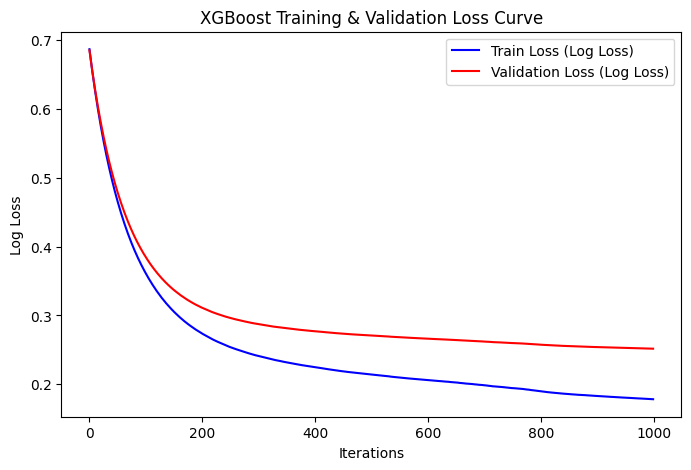

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92    599114
           1       0.65      0.86      0.74    145192

    accuracy                           0.88    744306
   macro avg       0.81      0.87      0.83    744306
weighted avg       0.90      0.88      0.89    744306



In [54]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.4
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [55]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[532110  67004]
 [ 20618 124574]]

True Positives (TP): 124574
False Positives (FP): 67004
True Negatives (TN): 532110
False Negatives (FN): 20618
